Workflow for YOLOR modeling


The original orthoimage, and resulting sliced tiles will be stored outside the repository directory due to size. 

after all pre-processing is completed, the final test, train tiles, and test annotations will be copied over to the repo data folder

# Pre-Processing and Exploratory Analysis

In [1]:
import rasterio 
import numpy as np
import pandas as pd

# Data and Viz Libraries
import requests
import matplotlib.pyplot as plt
import time
from google.oauth2 import service_account

# Libraries for custom tile slicing functions
import os
import shutil
import csv
import json
import random
from tqdm import tqdm
from rasterio.features import geometry_mask
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_geom

In [108]:
file = "F:\OneDrive - Grand Valley State University\_CAPSTONE\data\chafee_clipped_compressed.tif"

In [25]:
img = rasterio.open(file)

In [2]:
# adapted from https://fractaldle.medium.com/satellite-images-deep-learning-spacenet-building-segmentation-a5d145a81c33
def get_tile_name_path(dst_dir:str, index:int):
    '''
    generating index specific tile name
    '''
    dst_tile_name = "{}_.tif".format(str(index).zfill(5))
    dst_tile_path = os.path.join(dst_dir, dst_tile_name)
    return dst_tile_name, dst_tile_path

def get_tile_transform(parent_transform, pixel_x:int,pixel_y:int):
    '''
    creating tile transform matrix from parent tif image
    '''
    crs_x = parent_transform.c + pixel_x * parent_transform.a
    crs_y = parent_transform.f + pixel_y * parent_transform.e
    tile_transform = rasterio.Affine(parent_transform.a, parent_transform.b, crs_x,
                                     parent_transform.d, parent_transform.e, crs_y)
    return tile_transform
    
def get_tile_profile(parent_tif:rasterio.io.DatasetReader, pixel_x:int, pixel_y:int):
    '''
    preparing tile profile
    '''
    tile_crs = parent_tif.crs
    tile_nodata = parent_tif.nodata if parent_tif.nodata is not None else 0
    tile_transform = get_tile_transform(parent_tif.transform, pixel_x, pixel_y)
    profile = dict(
                driver="GTiff",
                crs=tile_crs,
                nodata=tile_nodata,
                transform=tile_transform
            )
    return profile

def generate_tiles(tif:rasterio.io.DatasetReader, size:int, dst_dir:str):
    i = 0
    for x in tqdm(range(0, tif.width, size)):
        for y in range(0, tif.height, size):
            # creating the tile specific profile
            profile = get_tile_profile(tif, x, y)
            # extracting the pixel data (couldnt understand as i dont think thats the correct way to pass the argument)
            tile_data = tif.read(window=((y, y + size), (x, x + size)),
                                 boundless=True, fill_value=profile['nodata'])[:3]
            i+=1
            dst_name, dst_tile_path = get_tile_name_path(dst_dir, i)
            c, h, w = tile_data.shape
            profile.update(
                height=h,
                width=w,
                count=c,
                dtype=tile_data.dtype,
            )
            with rasterio.open(dst_tile_path, "w", **profile) as dst:
                dst.write(tile_data)


In [8]:
mask_src = rasterio.open("F:/masked.tif")
img = rasterio.open("F:/chafee_clipped_compressed.tif")

dst_mask_dir = "F:/masks"
dst_image_dir = "F:/tiles"

Slices the image composite for the county into 12,000 1,000 x 1,000 pixel tiles which retain original projection information

In [11]:
#generate_tiles(mask_src, 1024, dst_mask_dir) # generating tiles for mask

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:59<00:00, 37.79s/it]


In [9]:
#generate_tiles(img, 1024, dst_image_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:16:49<00:00, 46.10s/it]


In [111]:
img_tmp = rasterio.open("../data/train_tiles/07452_.tif")
mask_tmp = rasterio.open("../data/train_masks/07452_.tif")

print(img_tmp.bounds)
print(img_tmp.shape)
print(img_tmp.crs)
print(img_tmp.profile)

print(mask_tmp.bounds)
print(mask_tmp.shape)
print(mask_tmp.crs)
print(mask_tmp.profile)

# Bounds should be identical, theres a slight difference here as my original mask had 1 fewer pixel in width due to an error but it should work still

BoundingBox(left=402169.2, bottom=4267861.19994269, right=402783.60000000003, top=4268475.599943304)
(1024, 1024)
EPSG:26913
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1024, 'height': 1024, 'count': 3, 'crs': CRS.from_epsg(26913), 'transform': Affine(0.6000000000000002, 0.0, 402169.2,
       0.0, -0.6000000006000009, 4268475.599943304), 'tiled': False, 'interleave': 'pixel'}
BoundingBox(left=402169.5875461991, bottom=4267861.199919437, right=402783.99360160844, top=4268475.599920313)
(1024, 1024)
EPSG:26913
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1024, 'height': 1024, 'count': 1, 'crs': CRS.from_epsg(26913), 'transform': Affine(0.6000059134857044, 0.0, 402169.5875461991,
       0.0, -0.6000000008551615, 4268475.599920313), 'tiled': False, 'interleave': 'band'}


In [112]:
r,g,b = img_tmp.read()
m = mask_tmp.read()

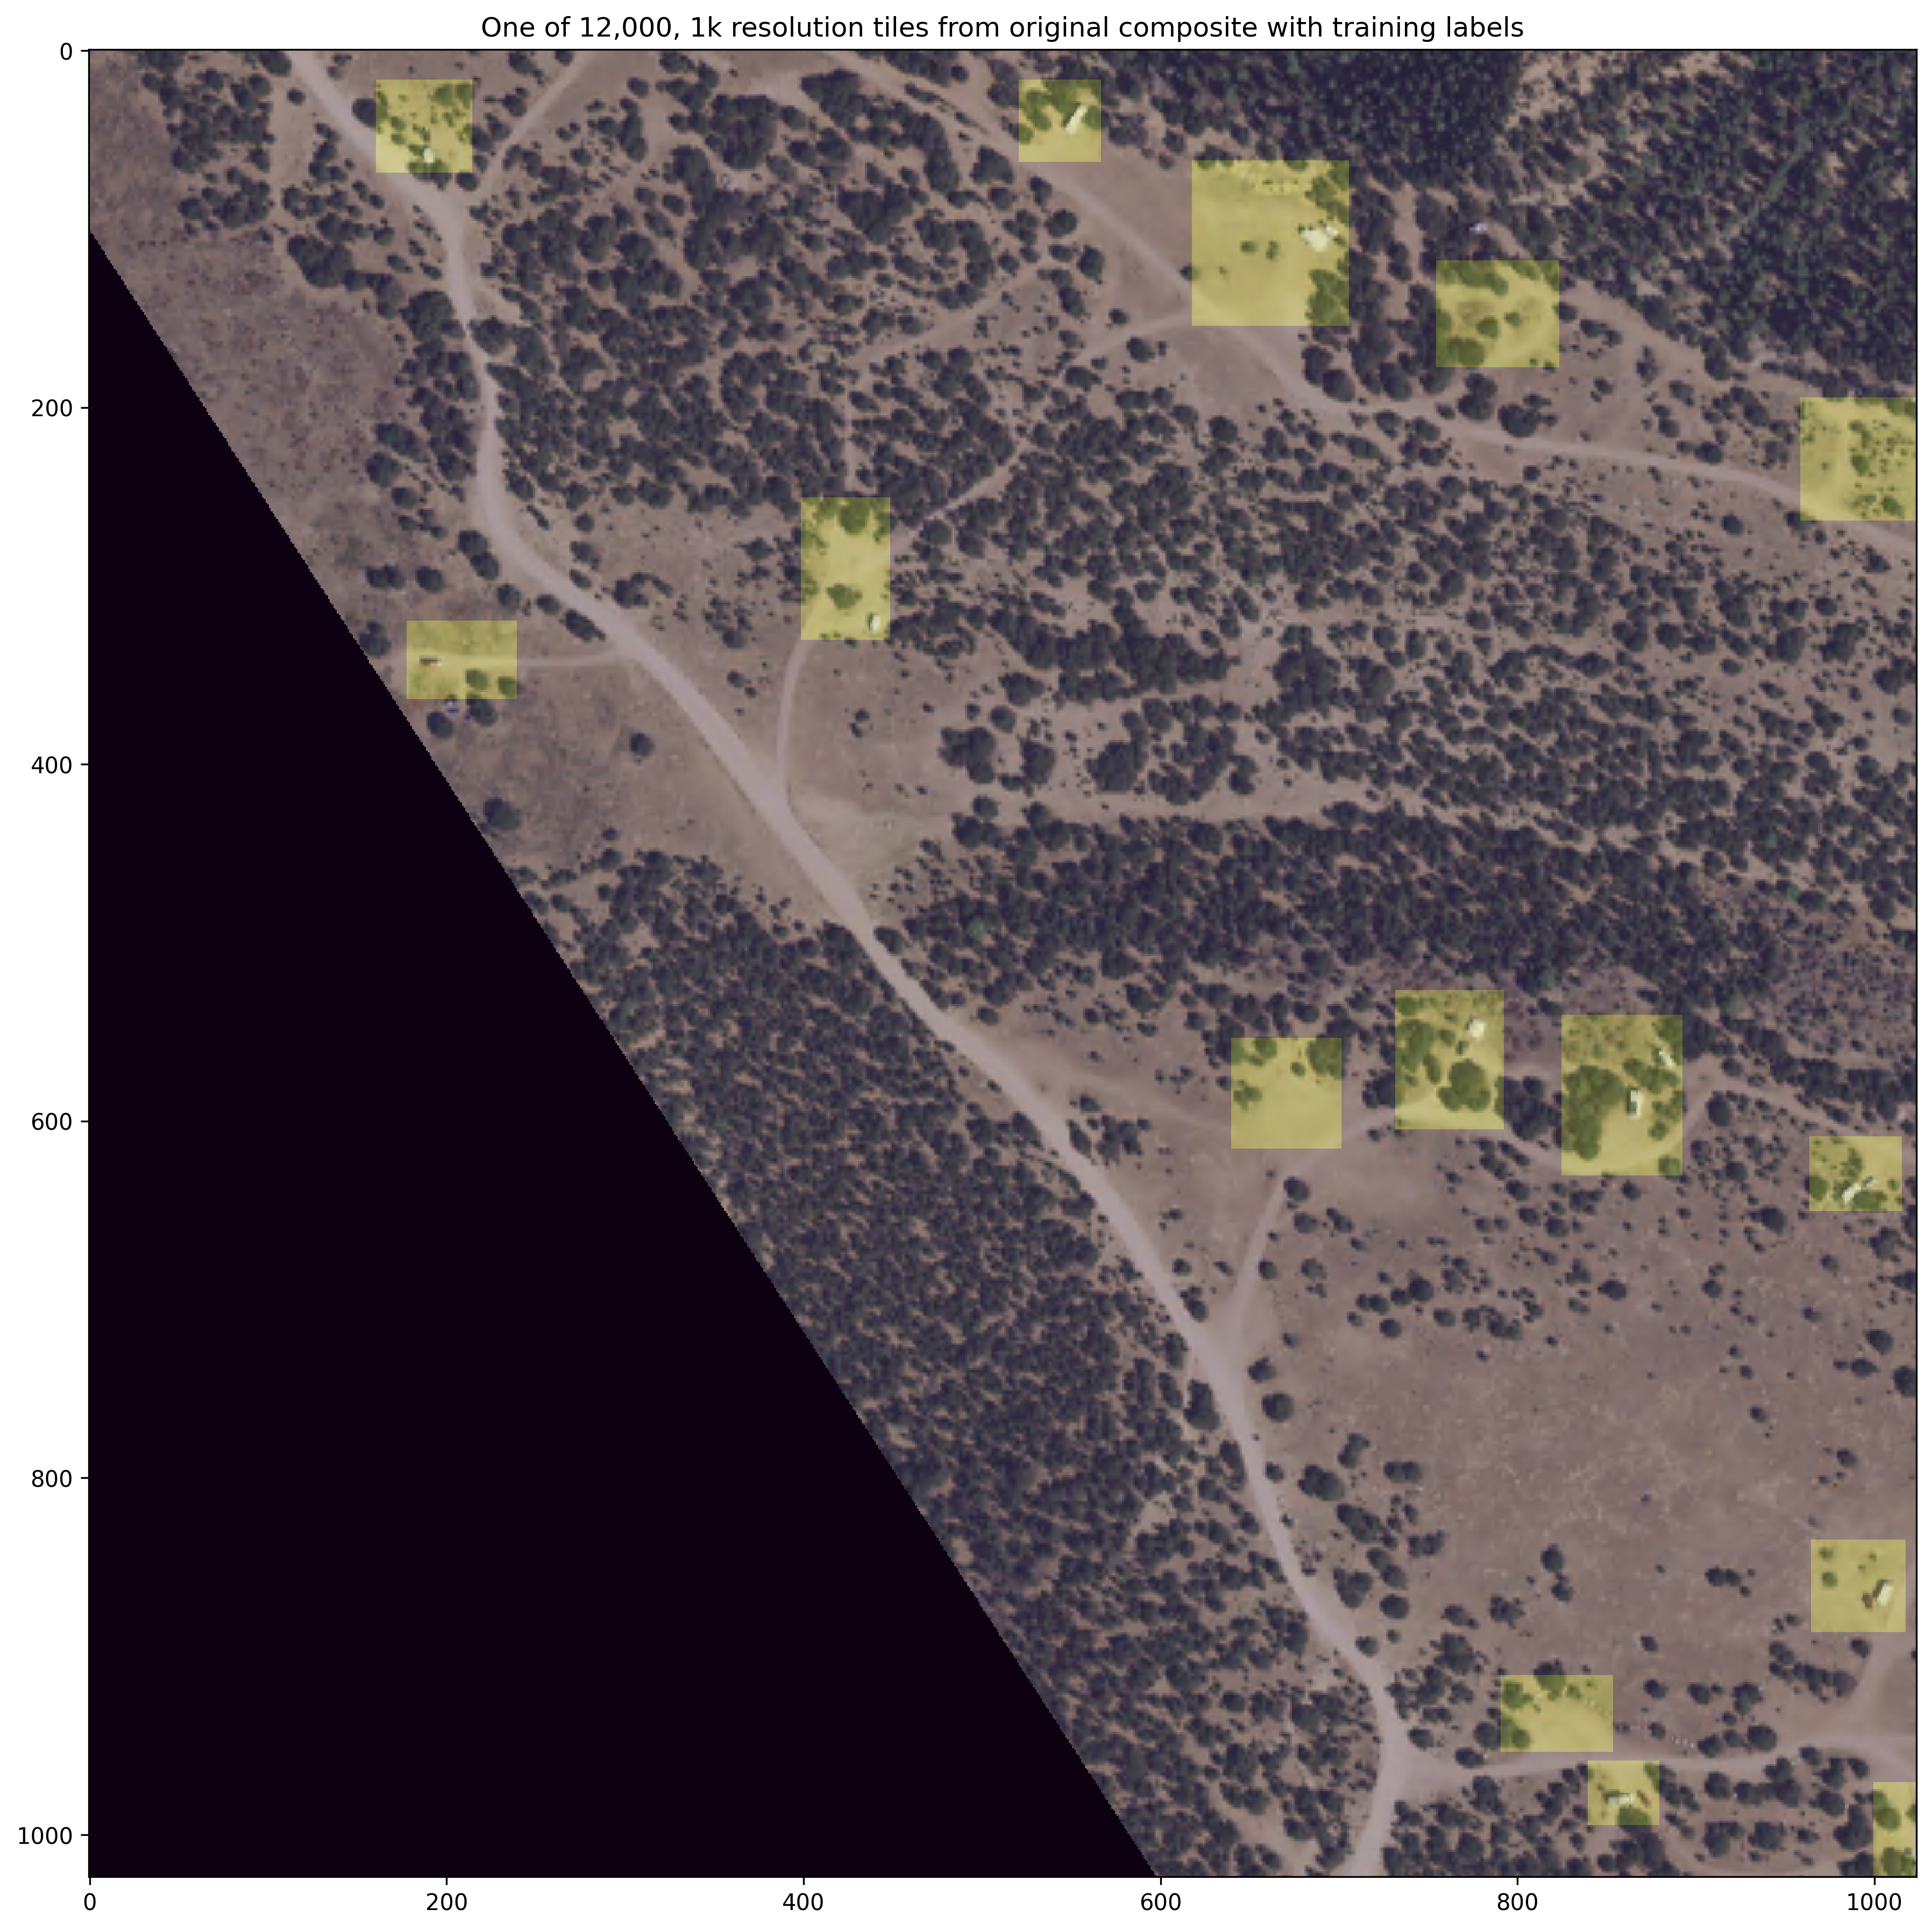

In [114]:
plt.figure(figsize=(15, 15), dpi = 300)
plt.imshow(img_tmp.read([1,2,3]).transpose(1, 2, 0));
plt.imshow(mask_tmp.read(1), alpha=0.2, vmin=0.5);
plt.title('One of 12,000, 1k resolution tiles from original composite with training labels')
plt.savefig('../output/tilemaskexample.png')

# Subsetting Training Data

Get list of valid tiles ( having some overlap with AOI) and tiles where bounding box masks are present ( training images )


- If tile contains no data for AOI, RGB array sum will be 0. 
- If tile contains no labels, mask array sum will be 0

In [2]:
tile_path = "F:/github/freedom-camping/data/tiles"
mask_path = "F:/github/freedom-camping/data/masks"

tile_paths = os.listdir(tile_path);
mask_paths = os.listdir(mask_path);

valid_tiles=[]
train_tiles=[]

for each in tile_paths:

    img_tmp = rasterio.open(f"{tile_path}/{each}")
    mask_tmp = rasterio.open(f"{mask_path}/{each}")
    rgb = img_tmp.read()
    m = mask_tmp.read()

    if (rgb.sum()) > 0:
        valid_tiles.append(each)
        if m.sum() > 0:
            train_tiles.append(each)

C:\Users\kendall\anaconda3\envs\pygis\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RasterioIOError: F:/github/freedom-camping/data/masks/03955_.jpeg: No such file or directory

In [10]:
print(f"number of valid tiles = {len(valid_tiles)}")
print(f"number of train tiles = {len(train_tiles)}")

number of valid tiles = 2375
number of train tiles = 82


Generate list of test tiles (tiles without bounding boxes) by taking all valid tiles not listed in train tiles

In [11]:
test_tiles =  [e for e in valid_tiles if e not in train_tiles] 

print(f"number of test tiles = {len(test_tiles)}")

number of test tiles = 2293


Save the list of training tiles, and test tiles as csv for safekeeping

In [22]:
filename = 'train_tile_list'
path = f"F:/github/freedom-camping/data/{filename}.csv"
with open(path, 'a'):
    os.utime(path, None)

In [40]:

def list_to_csv(mylist, filename):
    path = f"F:/github/freedom-camping/data/{filename}.txt"
    out = csv.writer(open(path,"w"), delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(mylist)
    return

list_to_csv(train_tiles, 'train_tile_list')
list_to_csv(test_tiles, 'test_tile_list')

In [11]:
import skimage.io

https://datacarpentry.org/image-processing/aio/index.html

https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

- We can use skimage.measure.label to find and label connected objects in an image.

- We can use skimage.measure.regionprops to measure properties of labeled objects.

In [28]:
m = skimage.io.imread(fname="../data/train_masks/03955_.jpeg")

In [29]:
# compute object features and extract object areas
object_features = skimage.measure.regionprops(m)
object_areas = [objf["area"] for objf in object_features]
object_areas

[7995]

In [30]:
object_features = skimage.measure.regionprops(m)

In [31]:
class - center_x - center_y - width - height

SyntaxError: invalid syntax (1001817372.py, line 1)

In [32]:
coords = object_features[0]['centroid'] # this is y,x so needs to be flipped for output

In [33]:
coords

(542.0067542213884, 376.48630393996245, 1.0)

In [34]:
y_top = object_features[0]['coords'][0][0]

In [35]:
y_bot = object_features[0]['coords'][-1][0]

In [36]:
height = abs(y_bot - y_top)
print(height)

36


In [40]:
x_left = object_features[0]['coords'][0][1]
x_right = object_features[0]['coords'][-1][1]

width = abs(x_right - x_left)
print(width)

norm_h = height/1024
norm_w = width/1024

norm_xcenter = coords[1] / 1024
norm_ycenter = coords[0] / 1024

71


In [41]:
yolo_annot = [['0', norm_xcenter, norm_ycenter, norm_w, norm_h]]

In [42]:
yolo_annot

[['0', 0.3676624061913696, 0.5293034709193246, 0.0693359375, 0.03515625]]

In [44]:
coords[]

376.48630393996245

In [111]:
import numpy as np
np.savetxt('../data/train_tiles/04308_.txt', 
           yolo_annot,
          delimiter = ' ',
           fmt ='% s'
          )

FileNotFoundError: [Errno 2] No such file or directory: '../data/train_tiles/04308_.txt'

DEBUGGING STUFF BELOW

In [128]:
m = skimage.io.imread(fname="../data/train_masks/04308_.jpeg")

In [138]:
object_features = skimage.measure.regionprops(m)
box_ycoords = np.array([int(objf["centroid"][0]) for objf in object_features])
box_xcoords = np.array([int(objf["centroid"][1]) for objf in object_features])
box_y_upbounds = np.array([objf["coords"][0][0] for objf in object_features])
box_y_lowbounds = np.array([objf["coords"][-1][0] for objf in object_features])
box_x_leftbounds = np.array([objf["coords"][0][1] for objf in object_features])
box_x_rightbounds = np.array([objf["coords"][-1][1] for objf in object_features])

    
heights = (box_y_lowbounds - box_y_upbounds) / 1024
#norm_y = (((box_y_lowbounds + box_y_upbounds) / 2) / 1240)
norm_y = (((box_y_lowbounds + box_y_upbounds) / 2) / 1024)
classes = []
classes = ['0' for box in object_features]
widths = (box_x_rightbounds - box_x_leftbounds) / 1024
norm_x = ((box_x_rightbounds + box_x_leftbounds) / 2) / 1024

In [139]:
yolo_annot = np.array([])

In [140]:
box_ycoords

array([379, 230])

In [149]:
max(box_ycoords)

379

In [141]:
box_y_lowbounds

array([763, 276], dtype=int64)

In [142]:
box_y_upbounds

array([108, 168], dtype=int64)

In [143]:
heights

array([0.63964844, 0.10546875])

In [135]:
(box_y_lowbounds - box_y_upbounds) / 1024

array([0.63964844, 0.10546875])

In [136]:
box_xcoords

array([452, 665])

In [146]:
box_x_rightbounds

array([ 23, 573], dtype=int64)

In [121]:
box_x_leftbounds

array([712, 759], dtype=int64)

In [125]:
(box_x_rightbounds - box_x_leftbounds) / 1240

array([-0.55564516, -0.15      ])

In [122]:
norm_x

array([0.35888672, 0.65039062])

In [123]:
norm_y

array([0.42529297, 0.21679688])

In [124]:
classes

['0', '0']

In [91]:
for i, class_id in enumerate(classes):

    yolo_annot = np.array([class_id, norm_x[i], norm_y[i], widths[i], heights[i]])

    if i > 0:
        print(f'{len(classes)} bounding boxes for {mask}')
        box_annot = np.array([class_id, norm_x[i], norm_y[i], widths[i], heights[i]])
        yolo_annot = np.concatenate((yolo_annot,box_annot))


np.savetxt(f'../data/train_labels/{mask[0:6]}.txt', 
           yolo_annot,
          delimiter = ' ',
           fmt ='% s'
          )

2 bounding boxes for 03964_.jpeg


### Combined all that to make an annotation function for each train image

In [98]:
import numpy as np
import os

train_masks = os.listdir("../data/train_masks")

for mask in train_masks:

    m = skimage.io.imread(fname = f"../data/train_masks/{mask}")

    object_features = skimage.measure.regionprops(m)
    box_ycoords = np.array([objf["centroid"][0] for objf in object_features])
    box_xcoords = np.array([objf["centroid"][1] for objf in object_features])
    #box_y_upbounds = np.array([objf["coords"][0][0] for objf in object_features])
    #box_y_lowbounds = np.array([objf["coords"][-1][0] for objf in object_features])
    #box_x_leftbounds = np.array([objf["coords"][0][1] for objf in object_features])
    #box_x_rightbounds = np.array([objf["coords"][-1][1] for objf in object_features])

    
    heights = (max(box_ycoords) - min(box_ycoords)) / 1240
    #norm_y = (((box_y_lowbounds + box_y_upbounds) / 2) / 1240)
    norm_y = ((sum(box_ycoords) / 2) / 1240)
    classes = []
    classes = ['0' for box in object_features]
    widths = (box_x_rightbounds - box_x_leftbounds) / 1240
    norm_x = ((sum(box_xcoords) / 2 ) / 1240)

    #norm_h = height/1024
    #norm_w = width/1024

    #norm_xcenters = coords[1] / width
    #norm_ycenters = coords[0] / height
    yolo_annot = np.array([])
    
    for i, class_id in enumerate(classes):

        yolo_annot = np.array([class_id, norm_x[i], norm_y[i], widths[i], heights[i]])

        if i > 0:
            print(f'{len(classes)} bounding boxes for {mask}')
            box_annot = np.array([class_id, norm_x[i], norm_y[i], widths[i], heights[i]])
            yolo_annot = np.stack((yolo_annot,box_annot))
            
        else:
            yolo_annot = np.array([[class_id, norm_x[i], norm_y[i], widths[i], heights[i]]])
            
    
    np.savetxt(f'../data/train_labels/{mask[0:6]}.txt', 
               yolo_annot,
              delimiter = ' ',
               fmt ='% s'
              )

2 bounding boxes for 03964_.jpeg
2 bounding boxes for 04185_.jpeg
2 bounding boxes for 04194_.jpeg
2 bounding boxes for 04308_.jpeg
2 bounding boxes for 04422_.jpeg
2 bounding boxes for 04838_.jpeg
2 bounding boxes for 04928_.jpeg
2 bounding boxes for 04953_.jpeg
2 bounding boxes for 05067_.jpeg
2 bounding boxes for 05068_.jpeg
2 bounding boxes for 05528_.jpeg
2 bounding boxes for 05787_.jpeg
2 bounding boxes for 06505_.jpeg
2 bounding boxes for 06735_.jpeg
2 bounding boxes for 06737_.jpeg
2 bounding boxes for 06740_.jpeg
2 bounding boxes for 06850_.jpeg
2 bounding boxes for 06852_.jpeg
2 bounding boxes for 06853_.jpeg
2 bounding boxes for 06854_.jpeg
2 bounding boxes for 06855_.jpeg
2 bounding boxes for 06857_.jpeg
2 bounding boxes for 06874_.jpeg
2 bounding boxes for 06875_.jpeg
2 bounding boxes for 06933_.jpeg
2 bounding boxes for 06972_.jpeg
2 bounding boxes for 06973_.jpeg
2 bounding boxes for 07082_.jpeg
2 bounding boxes for 07105_.jpeg
2 bounding boxes for 07163_.jpeg
2 bounding

Convert TIF images to JPEG for modeling & move over training tiles, training annotations, test tiles to repo data directory

Train Tiles & Annotations

In [ ]:
for infile in train_tiles:
    
    src = "F:/github/freedom-camping/data/tiles/"
    train_dir = "F:/github/freedom-camping/data/train/"
    inpath = f"{src}{infile}"
    outfile = train_dir + infile[:-3] + "jpeg"
    im = Image.open(inpath)
    out = im.convert("RGB")
    out.save(outfile, "JPEG", quality=100)

   
    #placeholder for copying annotations as well

Test Tiles & Annotations

In [ ]:
for infile in test_tiles:
    
    src = "F:/github/freedom-camping/data/tiles/"
    test_dir = "F:/github/freedom-camping/data/test/"
    inpath = f"{src}{infile}"
    outfile = test_dir + infile[:-3] + "jpeg"
    im = Image.open(inpath)
    out = im.convert("RGB")
    out.save(outfile, "JPEG", quality=100)

In [14]:
train_masks = os.listdir("../data/train")

In [9]:
train_masks;

infile = train_masks[0]

infile = infile[:6] + ".tif"

infile

'03955_.tif'

In [16]:
from PIL import Image

for infile in train_masks:
    
    infile = infile[:6] + ".tif"
    
    src = "F:/github/freedom-camping/data/masks/"
    train_dir = "F:/github/freedom-camping/data/train_masks/"
    inpath = f"{src}{infile}"
    outfile = train_dir + infile[:-3] + "jpeg"
    im = Image.open(inpath)
    out = im.convert("RGB")
    out.save(outfile, "JPEG", quality=100)

   
    #placeholder for copying annotations as well